<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/06_Transfer_Learning_Part3_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Mar 26 08:12:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Transfer Learning with TensorFlow - Scaling Up 
We've seen the power of transfer learning feature extraction and fine-tuning now it's time to scale up to all of the classes in Food101 (101 classes). 

Our goal is to beat original Food101 paper with 10% of the training data, leveraging the power of the transfer learning. Our baseline is to beat 50.76% accuracy across 101 classes.

### Thing's to cover 
- Downloading $ preparing 10% of all Food101 classes (7500+ training images). 
- Training a **transfer learning feature extraction** model. 
- Fine-tuning our feature extraction model(👁 Food Vision mini) to beat the original Food101 paper with only 10% of the data. 
- Evaluating Food Vision mini's predictions. 
  - Finding the most wrong prediction (on the test data). 
- Making **predictions with the Food Vision mini on our custom images**.



## Creating Helper function 
In previous notebook, we've created a series of helper function to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-03-26 08:12:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9304 (9.1K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.09K  --.-KB/s    in 0s      

2021-03-26 08:12:56 (36.6 MB/s) - ‘helper_functions.py’ saved [9304/9304]



In [3]:
# Import series of helper function for our notebook 
from helper_functions import  create_tensorboard_callback , unzip_data , plot_loss_curves , compare_historys , walk_through_dir

## 101 Food Classes: workking with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it. 

The data we're downloading comes from original Food101 dataset but has been preprocessed using the `image_data_modification.ipynb`

In [4]:
# Getting the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2021-03-26 08:12:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 2404:6800:4008:c01::80, 2404:6800:4008:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  97.9MB/s    in 18s     

2021-03-26 08:13:17 (87.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images classes are there 
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_

In [6]:
# Setup data inputs 
import tensorflow as tf
IMG_SIZE = (224 , 224)

# Loading in the data
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir , 
                                                                                image_size = IMG_SIZE , 
                                                                                batch_size = 32 , 
                                                                                label_mode = 'categorical') 

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir , 
                                                                label_mode = 'categorical' , 
                                                                image_size = IMG_SIZE, 
                                                                shuffle = False) # don't shuffle data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
print('Hello World')

Hello World


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take: 
- Create a `ModelCheckpoint` callback.
- Create **data augmentation layer** to build data augmentation right into the model. 
- Build a headless (no top layers) Functional EfficientNet B0 backboned-model(we'll create our own output layer). 
- Compile our model 
- Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data to save epoch time). 

In [8]:
# Create checkpoint callback 
checkpoint_path = '101_food_classes_10_percent_data_model_checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path , 
                                                         monitor = 'val_accuracy' ,  # stores higher accuracy
                                                         save_weights_only = True )

In [9]:
# Create data augmentation layer to incorporate it right into the model 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

# Setup data augmentation 
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomWidth(0.2), 
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomHeight(0.2) , 
  preprocessing.RandomZoom(0.2)
] , name = 'data_augmentation_layer')


In [10]:
# Setup the base model and freeze it's layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # backboned-model

# Freezing the base model (freeze all of the patterns)
base_model.trainable = False

# Setup model architecture with trainable top layers 
inputs = layers.Input(shape = (224 , 224, 3) ,name = 'input_layer')
x = data_augmentation(inputs) # Augment images only happens during training 
x = base_model(x , training = False) # puts the base model in inference mode so weights which need to stay frozen, stays frozen
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pool_2D_layer')(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names) , activation='softmax' , name = 'output_layer')(x)

# Packing into a model 
model = tf.keras.Model(inputs , outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [11]:
# Checking the summary of the model 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pool_2D_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [12]:
# Compile the model 
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics = ['accuracy'])

In [13]:
# Fitting the model 
history_all_class_10_percent = model.fit(train_data_all_10_percent , 
                                         epochs = 5 , 
                                         validation_data = test_data , 
                                         validation_steps = int(0.25 * len(test_data)) , 
                                         callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 193s 664ms/step - loss: 4.0132 - accuracy: 0.1445 - val_loss: 2.6747 - val_accuracy: 0.3639
Epoch 2/5
237/237 [==============================] - 125s 526ms/step - loss: 2.4204 - accuracy: 0.4570 - val_loss: 2.2614 - val_accuracy: 0.4329
Epoch 3/5
237/237 [==============================] - 120s 505ms/step - loss: 2.0363 - accuracy: 0.5144 - val_loss: 2.0942 - val_accuracy: 0.4619
Epoch 4/5
237/237 [==============================] - 113s 476ms/step - loss: 1.7804 - accuracy: 0.5714 - val_loss: 1.9705 - val_accuracy: 0.4864
Epoch 5/5
237/237 [==============================] - 111s 465ms/step - loss: 1.6328 - accuracy: 0.6055 - val_loss: 1.9712 - val_accuracy: 0.4799


In [14]:
# Let's evaluate on the whole test data 
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 145s 184ms/step - loss: 1.7300 - accuracy: 0.5461


After we evaluated our model on the whole test set, we got a accuracy of **`55%`** and we beat the paper!!! 

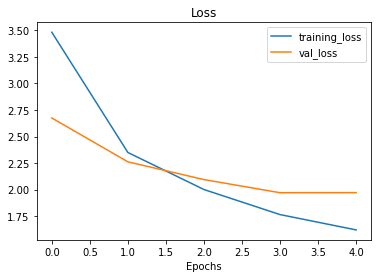

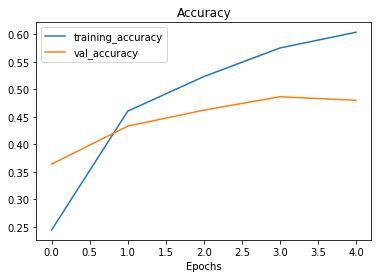

In [15]:
# Let's watch the loss curves 
plot_loss_curves(history_all_class_10_percent)

> **Question** What do these curves suggest? 
Ideally, the two curves should be similar to each other if not.. Overfitting!

They should be close to eachother, it seems if we are gonna train for more epochs our results might get worse as we train for more epochs. 

## Fine-tuning 

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True 

# Refreeze every layer except the last 5 
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
# Compile the model (it's best practice to lower the learning rate when fine-tuning)
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001) , # learning rate lowered
              metrics = ['accuracy'])

In [18]:
# What layers in the model are trainable 
for layer in model.layers:
  print(layer.name , layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_average_pool_2D_layer True
output_layer True


In [19]:
# Check which layers are trainable in our base_model 
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name , layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [20]:
# Fitting our model and fine_tuning it
initial_epochs = 5 
fine_tune_epochs = initial_epochs + 5
history_all_classes_fine_tune_10_percent = model.fit(train_data_all_10_percent , 
                                                     epochs = fine_tune_epochs , 
                                                     validation_data = test_data , 
                                                     validation_steps = int(0.15 * len(test_data)) , 
                                                     initial_epoch = history_all_class_10_percent.epoch[-1] )

Epoch 5/10
237/237 [==============================] - 100s 393ms/step - loss: 1.4243 - accuracy: 0.6390 - val_loss: 1.8955 - val_accuracy: 0.5072
Epoch 6/10
237/237 [==============================] - 88s 370ms/step - loss: 1.2617 - accuracy: 0.6623 - val_loss: 1.8628 - val_accuracy: 0.5138
Epoch 7/10
237/237 [==============================] - 86s 361ms/step - loss: 1.1806 - accuracy: 0.6848 - val_loss: 1.8473 - val_accuracy: 0.5201
Epoch 8/10
237/237 [==============================] - 83s 350ms/step - loss: 1.1011 - accuracy: 0.6957 - val_loss: 1.8678 - val_accuracy: 0.5156
Epoch 9/10
237/237 [==============================] - 82s 342ms/step - loss: 1.0586 - accuracy: 0.7156 - val_loss: 1.8942 - val_accuracy: 0.5159
Epoch 10/10
237/237 [==============================] - 79s 332ms/step - loss: 0.9987 - accuracy: 0.7355 - val_loss: 1.8471 - val_accuracy: 0.5260


In [21]:
history_all_class_10_percent.epoch[-1]

4

In [22]:
# Evaluate on the whole test data 
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 146s 185ms/step - loss: 1.6193 - accuracy: 0.5755


In [23]:
# Results for feature extraction 
feature_extraction_results

[1.72998046875, 0.5460990071296692]

Hmm, there isn't a much difference. After fine-tuning the accuracy increased only by 2%. 

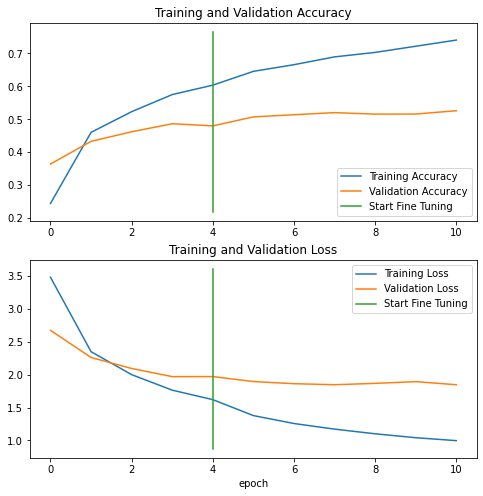

In [24]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(history_all_class_10_percent , 
                 history_all_classes_fine_tune_10_percent , 
                 initial_epochs = 5)

Observing the plot, it seems our model is overfitting on the training data. 

## Improving the model 
In here I will give my best to try and improve the model. Let's see how it goes...

The following experiments will be: 
- `model_exp_1` --> With fewer data augmentation layers (0-3), run for more epochs and see how it turns out. 
- `model_exp_2` --> Same fewer layers but tweak the values in that , run for more epochs. 
- `model_exp_3` --> Add more data augmentation layers with default values, run for 5 epochs. 
- `model_exp_4` --> Add more data augmentation layers with default values, run for more epochs. 
- `model_exp_5` --> Fewer data augmentation layer with tweaking values, run for more epochs. 

Will work with `interpolation = 'nearest'` for two experiments if the results aren't good will change it back to `bilinear`

In [25]:
# Creating a callback for our experimentation 
checkpoint_path_exp = '101_food_classes_improving_model'

checkpoint_callback_exp = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path_exp , 
                                                             save_weights_only = True , 
                                                             save_best_only = False , 
                                                             save_freq = 'epoch' , 
                                                             verbose = 1 , 
                                                             monitor ='val_accuracy')

In [26]:
# Checking what's in our data 
walk_through_dir('/content/101_food_classes_10_percent')

There are 2 directories and 0 images in '/content/101_food_classes_10_percent'.
There are 101 directories and 0 images in '/content/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '/content/101_fo

In [27]:
# Now let's check what was the previous accuracy we gotta beat
print(f'This is the accuracy we gotta beat: {all_classes_10_percent_fine_tune_results[1]:.3%}')

This is the accuracy we gotta beat: 57.552%


In [28]:
# Let's import our data
BATCH_SIZE = 32
INTERPOLATION = 'nearest'
train_data_exp_1 = tf.keras.preprocessing.image_dataset_from_directory(train_dir , 
                                                                       image_size = IMG_SIZE , 
                                                                       batch_size = BATCH_SIZE , 
                                                                       interpolation = INTERPOLATION , 
                                                                       shuffle = True , 
                                                                       label_mode = 'categorical')


Found 7575 files belonging to 101 classes.


We already have test data, only making changes in the **train_data**


#### `model_exp_1` With fewer data augmentation layers (0-3), run for more epochs and see how it turns out (EfficientNet B1)

In [29]:
# Now let's work on constructing our data augmentation layer 
# Fewer data augmentation layers
data_augmentation_exp_1 = Sequential([
  preprocessing.RandomFlip(), # default horiz and vertical
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.3)
])

In [30]:
# Now contructing a feature extraction model 

# Input shape 
inputs = layers.Input(shape=(224 , 224 , 3) , name = 'input_layer')

# Creating the base model (back-boned one)
base_model = tf.keras.applications.EfficientNetB1(include_top= False)
# Freezing all the layers 
base_model.trainable = False 

# Adding our data augmentation layer
x = data_augmentation_exp_1(inputs) 

# Now time for our base_model into action 
x = base_model(x , training = False)

# Condensing the tensors out from our base_model 
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_2D_layer')(x)

# Dense layer with our output classes 
outputs = layers.Dense(len(train_data_exp_1.class_names) , activation ='softmax',name = 'output_layer')(x)

# Wrapping in a model 
model_exp_1 = tf.keras.Model(inputs , outputs)

27025408/27018416 [==============================] - 2s 0us/step


In [31]:
# Checking the summary of our model 
model_exp_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, None, None, 1280)  6575239   
_________________________________________________________________
global_average_pooling_2D_la (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 6,704,620
Trainable params: 129,381
Non-trainable params: 6,575,239
_________________________________________________________________


In [32]:
# Let's compile and fit the extraction model for 5 epochs 
model_exp_1.compile(loss = tf.keras.losses.CategoricalCrossentropy() , 
                    optimizer = tf.keras.optimizers.Adam(), 
                    metrics = ['accuracy'])

history_exp_extractor_1 = model_exp_1.fit(train_data_exp_1 , 
                                          epochs = 5 , 
                                          validation_data = test_data , 
                                          validation_steps = int(0.25 * len(test_data)) , 
                                       callbacks = [checkpoint_callback_exp])

Epoch 1/5
237/237 [==============================] - 123s 478ms/step - loss: 4.1153 - accuracy: 0.1265 - val_loss: 2.7994 - val_accuracy: 0.3745

Epoch 00001: saving model to 101_food_classes_improving_model
Epoch 2/5
237/237 [==============================] - 113s 476ms/step - loss: 2.6335 - accuracy: 0.4010 - val_loss: 2.3742 - val_accuracy: 0.4262

Epoch 00002: saving model to 101_food_classes_improving_model
Epoch 3/5
237/237 [==============================] - 113s 473ms/step - loss: 2.2247 - accuracy: 0.4727 - val_loss: 2.1691 - val_accuracy: 0.4661

Epoch 00003: saving model to 101_food_classes_improving_model
Epoch 4/5
122/237 [==============>...............] - ETA: 32s - loss: 1.9786 - accuracy: 0.5264

KeyboardInterrupt: ignored

In [ ]:
# Check which layers are tuneable in the base model 
for layer_number , layer in enumerate(model_exp_1.layers):
  print(layer_number , layer.name , layer.trainable)

In [ ]:
# Now it's time to unfreeze the last 5 or so layers and fine tune the model 

# Unfreezing all layer 
base_model.trainable = True

# Re-Freeze all layers except except for the 
for layer in base_model.layers[:-5]: 
  layer.trainable = False

In [ ]:
# Making changes by compiling the model 
model_exp_1.compile(loss = tf.keras.losses.CategoricalCrossentropy() , 
                    optimizer = tf.keras.optimizers.Adam(lr = 0.0001) , 
                    metrics = ['accuracy'])

In [ ]:
# Now it's again time to check which models are trainable (EfficientNet should be True)
for layer in model_exp_1.layers:
  print(layer.name , layer.trainable)

In [ ]:
# Cool! Let's get into our base model and see what layers are exactly trainable 
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name , layer.trainable)

In [ ]:
# Fine tuning our model 
fine_tune_epochs = initial_epochs + 5 

# Refit the model 
history_fine_tune_exp1 = model_exp_1.fit(train_data_exp_1 , 
                                         epochs = fine_tune_epochs , 
                                         validation_data = test_data , 
                                         validation_steps = int( 0.25 * len(test_data)) , 
                                         initial_epoch = history_exp_extractor_1.epoch[-1] , 
                                         callbacks = [checkpoint_callback_exp])

In [ ]:
# Now testing on the whole test data
model_exp_1_results = model_exp_1.evaluate(test_data)

In [ ]:
all_classes_10_percent_fine_tune_results

In [ ]:
# Let's plot loss curves 
compare_historys(history_exp_extractor_1 , 
                 history_fine_tune_exp1 , 
                 initial_epochs = 5)

Hmm.. There is no much improvement. As we can see the validation accuracy getting worse as we train for more epochs. Let's try another experimentation with different model settings and by adding more augmentation layers and setting `interpolation = 'bilinear'`

In [ ]:
print('Hello World')

#### `model_exp_2` --> More layers but tweak the values in that , run for more epochs and set `interpolation = 'bilinear'`

In [ ]:
# Let's import our data
BATCH_SIZE = 32
INTERPOLATION = 'bilinear'
train_data_exp_2 = tf.keras.preprocessing.image_dataset_from_directory(train_dir , 
                                                                       image_size = IMG_SIZE , 
                                                                       batch_size = BATCH_SIZE , 
                                                                       interpolation = INTERPOLATION , 
                                                                       shuffle = True , 
                                                                       label_mode = 'categorical')

# Creating a callback for our experimentation 
checkpoint_path_exp_2 = '101_food_classes_improving_model_exp2'

checkpoint_callback_exp_2 = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path_exp_2 , 
                                                             save_weights_only = True , 
                                                             save_best_only = False , 
                                                             save_freq = 'epoch' , 
                                                             verbose = 1 , 
                                                             monitor ='val_accuracy')

In [ ]:
# Getting the data augmentation layer
data_augmentation_exp_2 = Sequential([
  preprocessing.RandomFlip(), 
  preprocessing.RandomWidth(0.3) , 
  preprocessing.RandomHeight(0.3) , 
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomZoom(0.4)
])

In [ ]:
# Let's build a model
input_shape = (224 , 224 , 3)

# Create a frozen base model 
base_model = tf.keras.applications.EfficientNetB1(include_top = False)
base_model.trainable = False

# Create inputs and output layers 
inputs = layers.Input(shape=input_shape , name ='input_layer')
x = data_augmentation_exp_2(inputs)
x = base_model(x , training = False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(train_data_exp_2.class_names) , activation='softmax' , name = 'output_layer')(x)

# Package a modek 
model_exp_2 = tf.keras.Model(inputs , outputs)

In [ ]:
# Check the summary of the model 
model_exp_2.summary()

In [ ]:
# Now let's compile and  run a feature extraction model 
model_exp_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                    optimizer = tf.keras.optimizers.Adam() , 
                    metrics = ['accuracy'])

history_exp_extractor_2 = model_exp_2.fit(train_data_exp_2 , 
                                          epochs = 5 , 
                                          validation_data = test_data , 
                                          validation_steps = int(0.25 * len(test_data)) , 
                                          callbacks = [checkpoint_callback_exp_2])

In [ ]:
# Evaluate on the test data 
model_exp_2.evaluate(test_data)

In [ ]:
# Now it's time to unfreeze all the layers 
base_model.trainable = True 

# Re-freeze all the layers except the last 7 layers
for layer in base_model.layers[:-7]:
  layer.trainable = False

# Compile the model 
model_exp_2.compile(loss = tf.keras.losses.CategoricalCrossentropy() , 
                    optimizer = tf.keras.optimizers.Adam(lr = 3e-4) , 
                    metrics = ['accuracy'])

# Which layers in our model is trainable 
for layer in model_exp_2.layers:
  print(layer.name , layer.trainable)

In [ ]:
# Now let's dig into the base_model and check the layers 
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name , layer.trainable)

In [ ]:
# Re-fit the model for fine-tuning 
fine_tune_epochs = initial_epochs + 10
history_fine_tune_exp2 = model_exp_2.fit(train_data_exp_2 , 
                                         epochs = fine_tune_epochs , 
                                         validation_data = test_data , 
                                         validation_steps = int(0.25 * len(test_data)) , 
                                         initial_epoch = history_exp_extractor_2.epoch[-1])

In [ ]:
# Evaluate on the whole test data 
results_exp_2_fine_tune = model_exp_2.evaluate(test_data)
results_exp_2_fine_tune

## Saving and loading our model 

To use our model in a external application will need to save and export it somewhere

In [33]:
# Save the fine tuning model 
model.save('model_here')

INFO:tensorflow:Assets written to: model_here/assets


In [34]:
# Load and evaluate with the saved model 
loaded_model = tf.keras.models.load_model('model_here')


In [35]:
# Evaluate loaded model and compare performance to presaved models 
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 156s 195ms/step - loss: 1.6193 - accuracy: 0.5755


In [36]:
# The results from our loaded model should be very similar to the results below 
all_classes_10_percent_fine_tune_results

[1.6193183660507202, 0.5755247473716736]

## Evaluating peformance of the big dog model across all different classes

Let's make some predictions,visualize them and then later find out which predictions where the **most wrong**.

In [37]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-03-26 08:49:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  22.2MB/s    in 2.0s    

2021-03-26 08:49:04 (22.2 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [38]:
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [39]:
# Load in the model which we downloaded moments before..
model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [40]:
# Check the summary 
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 101)               129381    
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [41]:
# Evaluate loaded model 
model.evaluate(test_data)

790/790 [==============================] - 156s 195ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027207851409912, 0.6077623963356018]

In [42]:
all_classes_10_percent_fine_tune_results

[1.6193183660507202, 0.5755247473716736]

## Making predictions with our trained model 


In [43]:
# Make predictions with model  (because we use softmax and it spits out array of prediciton probabilities)
preds_probs =  model.predict(test_data , verbose = 1) # see how long is left

790/790 [==============================] - 150s 188ms/step


In [44]:
# How many predictions are there 
len(preds_probs)

25250

In [45]:
25250 * 101

2550250

In [46]:
# Shape of our predictions 
preds_probs.shape

(25250, 101)

In [47]:
# Let see what the first 10 predictions look like 
preds_probs[:10]

array([[5.9542365e-02, 3.5742380e-06, 4.1376989e-02, ..., 1.4138919e-09,
        8.3531530e-05, 3.0897669e-03],
       [9.6401691e-01, 1.3753039e-09, 8.4780302e-04, ..., 5.4286538e-05,
        7.8363262e-12, 9.8466790e-10],
       [9.5925879e-01, 3.2534117e-05, 1.4866935e-03, ..., 7.1891890e-07,
        5.4398049e-07, 4.0276391e-05],
       ...,
       [4.7313297e-01, 1.2931194e-07, 1.4805554e-03, ..., 5.9749780e-04,
        6.6969653e-05, 2.3469136e-05],
       [4.4571746e-02, 4.7265476e-07, 1.2258559e-01, ..., 6.3498919e-06,
        7.5319153e-06, 3.6778722e-03],
       [7.2438931e-01, 1.9249764e-09, 5.2310719e-05, ..., 1.2291402e-03,
        1.5793009e-09, 9.6395699e-05]], dtype=float32)

In [48]:
# What does the first prediction prob looks like 
preds_probs[0] , len(preds_probs[0])

(array([5.9542365e-02, 3.5742380e-06, 4.1376989e-02, 1.0660797e-09,
        8.1614733e-09, 8.6639638e-09, 8.0925633e-07, 8.5652727e-07,
        1.9858839e-05, 8.0977213e-07, 3.1727312e-09, 9.8674104e-07,
        2.8531923e-04, 7.8049323e-10, 7.4231526e-04, 3.8916223e-05,
        6.4740229e-06, 2.4977014e-06, 3.7891594e-05, 2.0678598e-07,
        1.5538433e-05, 8.1506852e-07, 2.6230912e-06, 2.0010681e-07,
        8.3827507e-07, 5.4215407e-06, 3.7391314e-06, 1.3150807e-08,
        2.7761410e-03, 2.8052178e-05, 6.8561751e-10, 2.5574704e-05,
        1.6688925e-04, 7.6409168e-10, 4.0452890e-04, 1.3150506e-08,
        1.7957424e-06, 1.4448282e-06, 2.3062862e-02, 8.2465419e-07,
        8.5367139e-07, 1.7138558e-06, 7.0526098e-06, 1.8402373e-08,
        2.8554078e-07, 7.9483289e-06, 2.0681923e-06, 1.8525253e-07,
        3.3620211e-08, 3.1522621e-04, 1.0410861e-05, 8.5448426e-07,
        8.4741843e-01, 1.0555483e-05, 4.4094952e-07, 3.7404458e-05,
        3.5306322e-05, 3.2489061e-05, 6.7314213e

In [49]:
# All of them should be close to 1 or 1 
sum(preds_probs[0])

1.0000000291413174

Our model outputs a prediction probabiltiy array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
# We get one prediction probability per class (in our case 101 classes so 101 probabilties)
print(f'Number of prediction probabilties for sample 0: {len(preds_probs[0])}')
print(f'What prediction probabilities sample 0 looks like:\n {preds_probs[0]}')

In [ ]:
print(f'The class with highest predicted probability for sample 0: {tf.argmax(preds_probs[0])}')

In [ ]:
# The label 
train_data_all_10_percent.class_names[52]

In [50]:
# Get pred class for each label
pred_classes = preds_probs.argmax(axis = 1)

# How do they look 
pred_classes[:10] # first 10

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [53]:
# How many preds classes we have? 
len(pred_classes)

25250

Now we've got predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [54]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [55]:
# To get our test labels we need to unravel our test_data BatchDataset (our test_data in batch of images and labels)
y_labels = []
for images , labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels are in preds proba, so we need in class index value (so we perform argmax)
y_labels[:10] # Look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [56]:
# How many y_labels (original test) are there 
len(y_labels)

25250

## Evaluating our model's prediction

One way to check that our model's predictions array is in same order as our test labels is to find the accuracy score.


In [57]:
# Let's try scikit-learn's accuracy score function and see what it comes up with. 
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels , pred_classes)

In [58]:
sklearn_accuracy

0.6077623762376237

In [59]:
# Importing the confusion matrix 
from helper_functions import make_confusion_matrix

In [60]:
# Get a list of classes 
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
make_confusion_matrix(y_true = y_labels , 
                      y_pred = pred_classes , 
                      classes = class_names , 
                      figsize = (150 , 150) , 
                      text_size = 30)

In [66]:

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix_updated(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

Hmm..that's big and scary. We need to make some tweaks to get these plots better. 

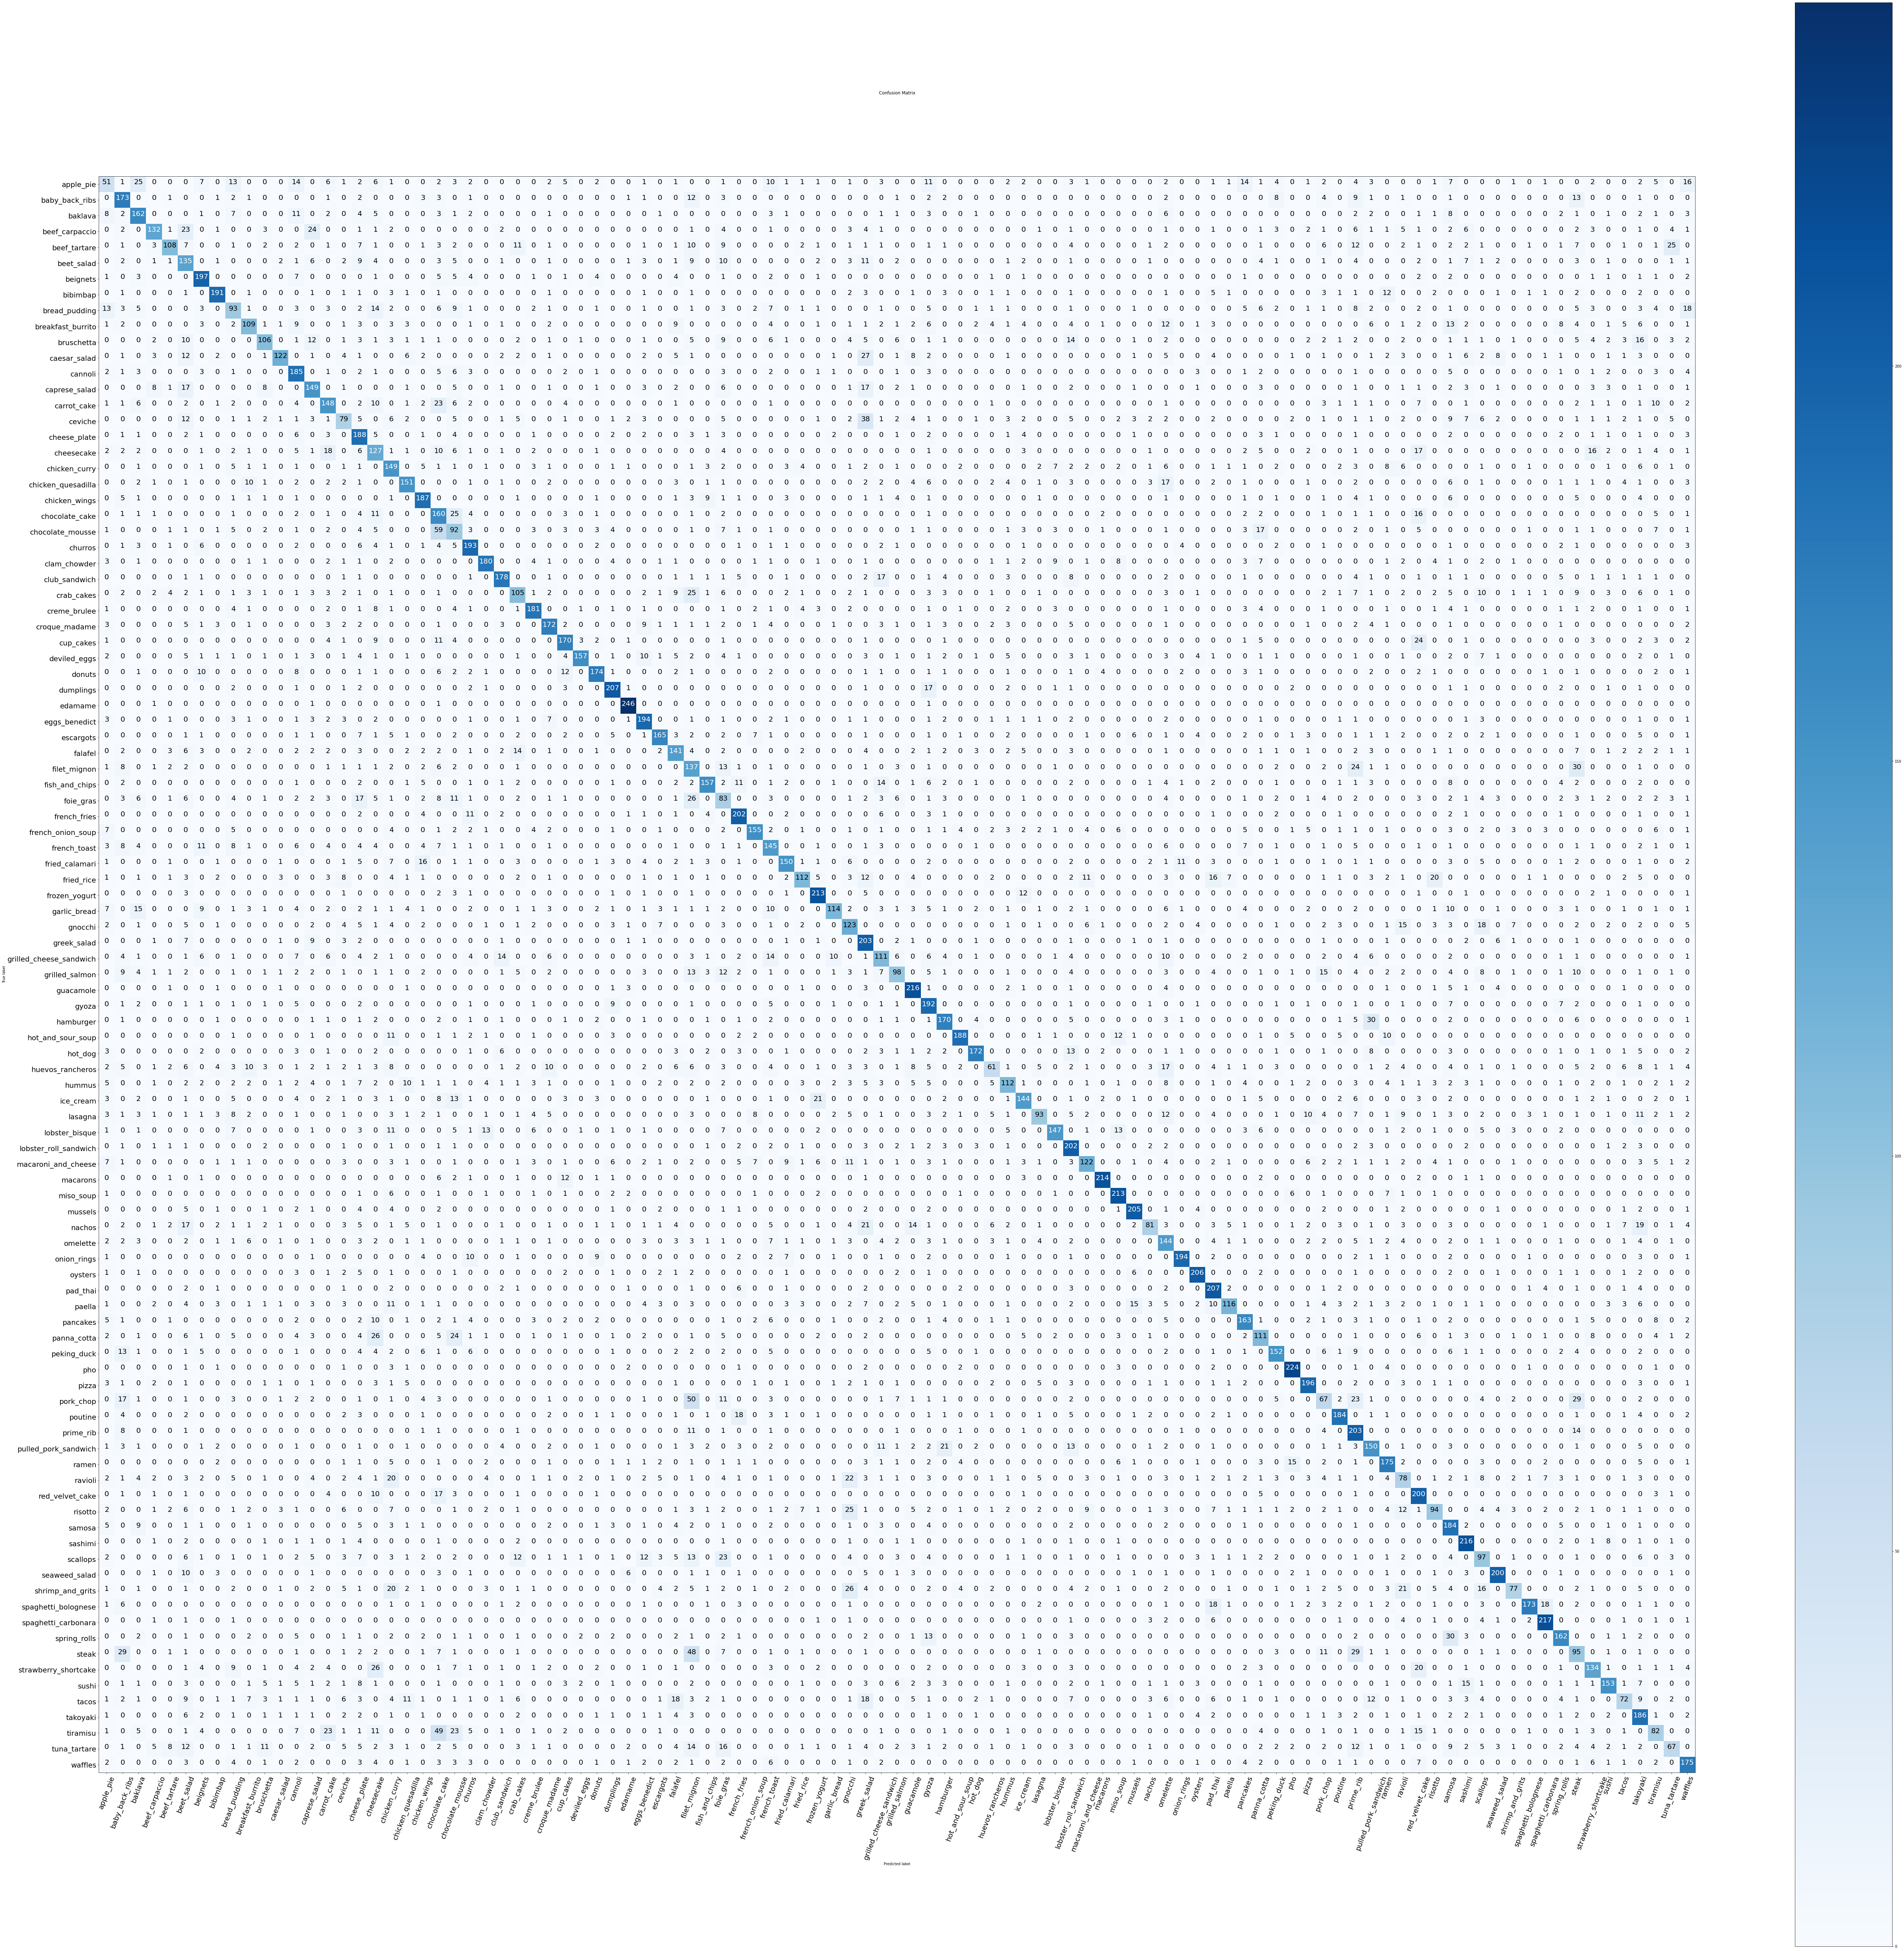

In [67]:
make_confusion_matrix_updated(y_true = y_labels , 
                      y_pred = pred_classes , 
                      classes = class_names , 
                      figsize = (100 , 100) , 
                      text_size = 20)

## Let's keep the evaluation train going, time for classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class(eg. precision, recall etc...) called `classification_report`

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_labels , pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

We could even check how our model does in all the classes, after observing we could see our model performs very well on some classes and poor on other classes.

The numbers above gives a great class-by-class evaluation of our model's predictions but with soo many classes they're quite hard to understand. How about we create a visualization to understand them. 

In [72]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels , pred_classes , output_dict= True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [76]:
# We have to encode 
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

Let's plot all of our classes F1-Score's 

In [78]:
# Doing this on large scale 
classification_report_dict['22']['f1-score']

0.3291592128801431

In [80]:
# Create empty dictionary 
class_f1_scores = {}
# Loop through classification report dictionary items
for k , v in classification_report_dict.items():
  if k == 'accuracy': # stop once we get to accuracy error
    break
  else:
    # Add class names 
    class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [81]:
# Turn f1-score into dataframes for visualization 
import pandas as pd 
f1_scores = pd.DataFrame({'class_names':list(class_f1_scores.keys()) , 
                          'f1-score': list(class_f1_scores.values())}).sort_values(by = 'f1-score' , ascending = False)

In [82]:
f1_scores

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491
